# Pembelajaran Mesin: Tugas Besar 1

Kaenova Mahendra Auditama  
IF-43-02  
1301190324  
  
Pada kodingan ini, saya mencoba untuk membuat sebuah model yang akan digunakan untuk membuat cluster pada suatu data. Data yang diberikan merupakan data ketertarikan pelanggan untuk membeli kendaraan baru. Pada akhirnya, saya menggunakan algoritma k-means karena kami diminta untuk membuat model dalam bentuk unsupervised learning
  
  
<sup>\*runs on AI Lab computer</sup>

# Import Library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pickle
import random
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from urllib.request import urlopen

# Import Data

In [3]:
df_raw = pd.read_csv("https://raw.githubusercontent.com/kaenova/Malin_Tubes1/main/data/raw/kendaraan_train.csv")
df_raw.head()

,id,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,1,Wanita,30.0,1.0,33.0,1.0,< 1 Tahun,Tidak,28029.0,152.0,97.0,0
1,2,Pria,48.0,1.0,39.0,0.0,> 2 Tahun,Pernah,25800.0,29.0,158.0,0
2,3,NaN,21.0,1.0,46.0,1.0,< 1 Tahun,Tidak,32733.0,160.0,119.0,0
3,4,Wanita,58.0,1.0,48.0,0.0,1-2 Tahun,Tidak,2630.0,124.0,63.0,0
4,5,Pria,50.0,1.0,35.0,0.0,> 2 Tahun,NaN,34857.0,88.0,194.0,0


In [4]:
len(df_raw)

285831

# Data Preprocessing

## Drop data yang ada NaN

In [5]:
df_dropna = df_raw.dropna(how="any")
len(df_dropna)

171068

## Drop data Categorical

In [12]:
df_dropna_dropcategorical = df_dropna.drop(axis=1, columns=["Jenis_Kelamin", "SIM", "Sudah_Asuransi", "Umur_Kendaraan", "Kendaraan_Rusak"])
df_dropna_dropcategorical.sample(5)

,id,Umur,Kode_Daerah,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
217132,217133,80.0,8.0,54312.0,26.0,88.0,0
41044,41045,48.0,20.0,2630.0,124.0,124.0,0
82212,82213,25.0,8.0,32810.0,152.0,223.0,0
194575,194576,25.0,41.0,64383.0,152.0,292.0,0
162584,162585,26.0,8.0,37148.0,152.0,274.0,0


## Check Outlier

Text(0.5, 1.0, 'Kode_Daerah')

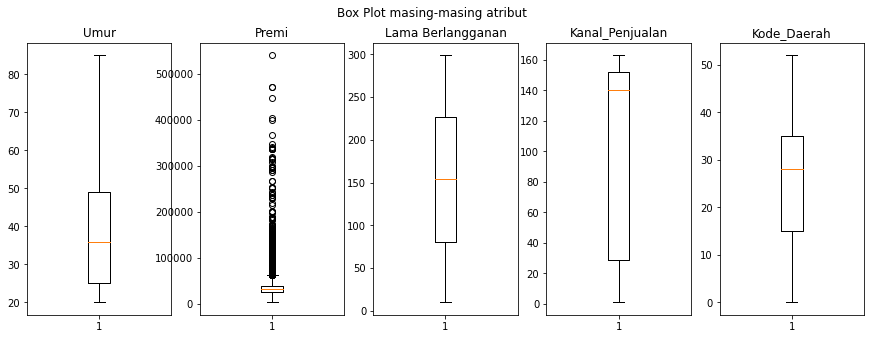

In [16]:
fig, (g1, g2, g3, g4, g5) = plt.subplots(1,5)
fig.suptitle("Box Plot masing-masing atribut")
fig.set_size_inches(15,5)
g1.boxplot(df_dropna_dropcategorical["Umur"])
g1.set_title("Umur")
g2.boxplot(df_dropna_dropcategorical["Premi"])
g2.set_title("Premi")
g3.boxplot(df_dropna_dropcategorical["Lama_Berlangganan"])
g3.set_title("Lama Berlangganan")
g4.boxplot(df_dropna_dropcategorical["Kanal_Penjualan"])
g4.set_title("Kanal_Penjualan")
g5.boxplot(df_dropna_dropcategorical["Kode_Daerah"])
g5.set_title("Kode_Daerah")

## Drop Outlier menggunakan IQR method

In [17]:
describe = df_dropna_dropcategorical.describe()
describe
iqr_premi = float(describe["Premi"].loc["75%"] - describe["Premi"].loc["25%"])
q1_bound = float(describe["Premi"].loc["25%"]) - (iqr_premi * 1.5)
q2_bound = float(describe["Premi"].loc["75%"]) + (iqr_premi * 1.5)
final_df = df_dropna_dropcategorical.copy()
final_df.reset_index(drop=True, inplace=True)
final_df = final_df[(final_df["Premi"] > q1_bound) & (final_df["Premi"] < q2_bound)]
len(final_df)

166396

Text(0.5, 1.0, 'Kode_Daerah')

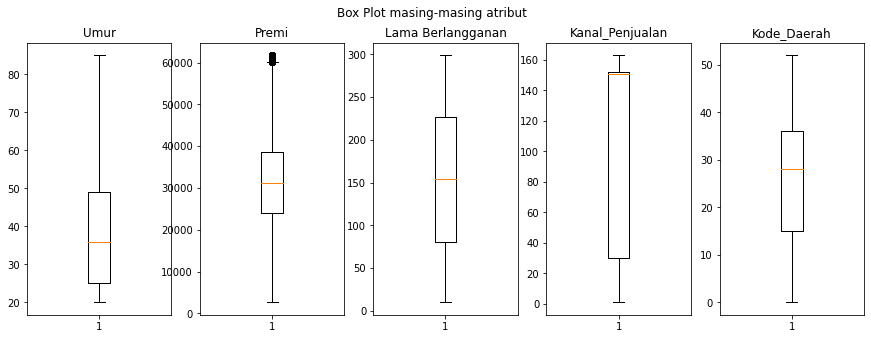

In [18]:
fig, (g1, g2, g3, g4, g5) = plt.subplots(1,5)
fig.suptitle("Box Plot masing-masing atribut")
fig.set_size_inches(15,5)
g1.boxplot(final_df["Umur"])
g1.set_title("Umur")
g2.boxplot(final_df["Premi"])
g2.set_title("Premi")
g3.boxplot(final_df["Lama_Berlangganan"])
g3.set_title("Lama Berlangganan")
g4.boxplot(final_df["Kanal_Penjualan"])
g4.set_title("Kanal_Penjualan")
g5.boxplot(final_df["Kode_Daerah"])
g5.set_title("Kode_Daerah")

## Check Correlation

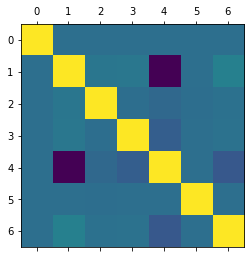

In [20]:
plt.matshow(final_df.corr())
plt.show()

In [19]:
final_df.corr()

,id,Umur,Kode_Daerah,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
id,1.000000,0.002691,0.000597,0.002643,-0.001621,0.001875,0.000203
Umur,0.002691,1.000000,0.044503,0.046519,-0.574807,-0.001055,0.108781
Kode_Daerah,0.000597,0.044503,1.000000,-0.004068,-0.044871,-0.003771,0.010484
Premi,0.002643,0.046519,-0.004068,1.000000,-0.105819,0.001831,0.019686
Kanal_Penjualan,-0.001621,-0.574807,-0.044871,-0.105819,1.000000,0.000017,-0.139186
Lama_Berlangganan,0.001875,-0.001055,-0.003771,0.001831,0.000017,1.000000,0.001819
Tertarik,0.000203,0.108781,0.010484,0.019686,-0.139186,0.001819,1.000000


Korelasi yang "menonjol" pada atribut umur dan kanal_penjualan

# Modelling

In [5]:
class KMeans:
  training_arr = None
  point = None
  inertia = None
  
  def __init__(self, df: pd.DataFrame):
    '''
    Kelas ini digunakan untuk menyiapkan dataframe yang akan ditraining.
    Pastikan kolom bernama id atau sejenis sudah di drop tidak termasuk ke dalam dataframe.
    '''
    print("K-Means akan ditentukan oleh atribut-atribut di bawah ini:")
    print("[", end="")
    for i in range(len(df.columns)):
      print(df.columns[i] + " ", end="")
    print("]", end="\n")
    self.training_arr = df.to_numpy()
    
  def fit_predict(self, k_num:int = 3, max_step:int = 500, conv_threshold: float = 1e-5) -> np.array:
    '''
    Membuat model KMeans dengan K tertentu. Akan mengkembalikan hasil prediksi cluster.
    Poin kluster akan disimpan pada variable point
    '''
    # Setting up cluster arry for every record
    cluster = np.zeros(len(self.training_arr))
    
    # normalize data
    data = self.__normalize_data__(self.training_arr)
    
    # Initialize centroid using KMeans++  
    point = self.__initialize_centroids__(data, k_num)
        
    # Setup convergence and counter
    convergence = False
    step = 0 
        
    while not convergence and (step < max_step):
      initial_point = point
      distance = self.__calculate_distance__(data, point)
      cluster = self.__clustering__(distance)
      new_point = self.__point_nomralization__(data, point, cluster)
      convergence = self.__convergence_check__(initial_point, new_point, conv_threshold)
      
      if convergence:
        point = new_point
        print("It's convergence!")
      else:
        point = new_point
        step += 1
        print("STEP:", step)
      
    
    self.inertia = self.__calculate_inertia__(data, cluster, point)
    self.point = self.__denormalize_point__(point, self.training_arr)
    return cluster
    
  # Made by Kaenova Mahendra Auditama | 1301190324 | IF-43-02
  def get_cluster_centroid(self) -> np.array:
    '''
    Fungsi ini digunakan untuk mengambil point
    '''
    if type(self.point) == "NoneType":
      print("Nothing returned, point not initialize. Try using fit_predict first.")
      return
    return self.point
  
  
  def __initialize_centroids__(self, data:np.array, k:np.array) -> np.array:
    '''
    Fungsi ini digunakan untuk menginisialisasikan centroid. Menggunakan algoritma k-means++
    referensi membantu: https://www.youtube.com/watch?v=HatwtJSsj5Q
    '''
    centroids = []
    centroids.append( data[random.randrange(0, len(data))] )
    
    for i in range(1, k):
      min_dist = []
      for data_point in data:
        distance_data_point = []
        for point in centroids:
          distance_data_point.append(np.linalg.norm(data_point - point))
        min_dist.append(min(distance_data_point))
      
      probcum  = sum(min_dist)
      prob_point = [value / probcum for value in min_dist]
      
      centroids.append(data[np.argmax(prob_point)])
    
    return np.array(centroids)
  
  
  def __clustering__(self, distance: np.array) -> np.array:
    '''
    Fungsi ini akan mengembalikan hasil clustering berdasarkan distance
    '''
    cluster = np.zeros(len(distance))
    for i in range(len(cluster)):
      cluster[i] = np.argmin(distance[i])
    return cluster
  # Made by Kaenova Mahendra Auditama | 1301190324 | IF-43-02
  def __calculate_distance__(self, data:np.array, point: np.array) -> np.array:
    '''
    Fungsi ini akan menghitung setiap titik dengan point dan mengkembalikan jarak dari titik ke point
    '''
    distance = np.zeros((len(data), len(point)))
    
    for i in range(len(data)):
      current_record = data[i]
      for j in range(len(point)):
        current_point = point[j]
        # numpy eucledience distance
        distance[i][j] = np.linalg.norm(current_point - current_record)
    
    return distance
  
  def __point_nomralization__(self, data:np.array, point:np.array, cluster:np.array) -> (np.array, np.array):
    '''
    Fungsi ini digunakan untuk menghitung ulang kembali point dengan rata-rata
    '''
    new_point = np.zeros((len(point), len(point[0])))
    counter_array = np.zeros(len(point))
    for i in range(len(cluster)):
      new_point[int(cluster[i])] = new_point[int(cluster[i])] + data[i]
      counter_array[int(cluster[i])] += 1
      
    unique_on_cluster = np.unique(cluster)
    for i in range(len(point)):
      # nan handling
      if i not in unique_on_cluster:
        new_point[i] = point[i]
      else:
        new_point[i] = np.true_divide(new_point[i], counter_array[i])
      
    return new_point
  # Made by Kaenova Mahendra Auditama | 1301190324 | IF-43-02
  def __convergence_check__(self, points1: np.array, points2:np.array, threshold: float) -> bool:
    '''
    Fungsi ini untuk mengecek convergence berdasarkan threshold yang dibuat.
    titik cluster pertama akan dibandingkan dengan titik cluster kedua.
    note: maybe i should use euclediance distance insted of menghitung satu-satu
    '''
    local_convergence = False
    normalize_threshold_positive, normalize_threshold_negative  = 1 + threshold, 1 - threshold
    points_counter = 0
    center = np.zeros(len(points1[0]))
    for i in range(len(points1)):
      current_first_point, current_second_point = points1[i], points2[i]
      distance_first_point, distance_second_point = np.linalg.norm(current_first_point - center), np.linalg.norm(current_second_point - center)
      distance_threshold_positive = distance_first_point * normalize_threshold_positive
      distance_threshold_negative = distance_first_point * normalize_threshold_negative
      if distance_threshold_positive > distance_second_point and distance_threshold_negative < distance_second_point:
        points_counter += 1
    
    if points_counter == len(points1):
      local_convergence = True
    
    return local_convergence
  
  def __calculate_inertia__(self, data:np.array, cluster:np.array, points:np.array) -> np.array:
    '''
    K-Means: Inertia
    Inertia measures how well a dataset was clustered by K-Means. It is calculated by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster.
    ref: https://towardsdatascience.com/clustering-how-to-find-hyperparameters-using-inertia-b0343c6fe819
    '''
    inertia = 0
    for i in range(len(data)):
      inertia += (np.linalg.norm(data[i] - points[int(cluster[i])]))**2
      
    return inertia
  
  def __normalize_data__(self, data:np.array) -> np.array:
    '''
    Fungsi ini digunakan untuk menormalisasikan data dengan menggunakan min-max scaling. Sehingga data berjenis dan bersatuan apapun data diproses dengan baik.
    '''
    data = data.copy()
    for i in range(len(data[0])):
      col_arr = data[:,i]
      minmax = MinMaxScaler()
      normalize = minmax.fit_transform(col_arr.reshape(-1,1)).reshape(1,-1)
      data[:, i] = normalize[0]
      
    return data
  
  def __denormalize_point__(self, data:np.array, original_data:np.array) -> np.array:
    '''
    Fungsi ini digunakan untuk mendenormalisasikan point-point yang sudah dihitung menggunakan data yang ternormalisasi
    '''
    for i in range(len(data[0])):
      col_arr = data[:,i]
      col_arr_ori = original_data[:, i]
      
      minimums = min(col_arr_ori)
      maximums = max(col_arr_ori)
      for j in range(len(col_arr)):
        col_arr[j] = ((col_arr[j]*(maximums - minimums)) + minimums)
      data[:, i] = col_arr
    return data

# Eksperimen Utama

In [21]:
df_training = final_df.copy()
df_training.set_index("id", inplace=True)
df_labels = df_training["Tertarik"]
df_training.drop(columns="Tertarik", axis=1, inplace=True)

In [22]:
df_training.head()

,Umur,Kode_Daerah,Premi,Kanal_Penjualan,Lama_Berlangganan
id,,,,,
1,30.0,33.0,28029.0,152.0,97.0
2,48.0,39.0,25800.0,29.0,158.0
4,58.0,48.0,2630.0,124.0,63.0
6,21.0,35.0,22735.0,152.0,171.0
9,20.0,8.0,30786.0,160.0,31.0


In [ ]:
# len(df_training)

In [5]:
# df_training.to_csv("../data/processed/kendaraan_train_processed.csv")
df_training = pd.read_csv("https://raw.githubusercontent.com/kaenova/Malin_Tubes1/main/data/processed/kendaraan_train_processed.csv")
df_training

,id,Umur,Kode_Daerah,Premi,Kanal_Penjualan,Lama_Berlangganan
0,1,30.0,33.0,28029.0,152.0,97.0
1,2,48.0,39.0,25800.0,29.0,158.0
2,4,58.0,48.0,2630.0,124.0,63.0
3,6,21.0,35.0,22735.0,152.0,171.0
4,9,20.0,8.0,30786.0,160.0,31.0
...,...,...,...,...,...,...
166391,285827,23.0,4.0,25988.0,152.0,217.0
166392,285828,21.0,46.0,44686.0,152.0,50.0
166393,285829,23.0,50.0,49751.0,152.0,226.0
166394,285830,68.0,7.0,30503.0,124.0,270.0


## 2 Atribut (Kanal Penjualan dan Umur)

In [37]:
# # No need to train again, i've already save the clusters
# # But if you want to try the training part, just uncomment this

# MAX_K = 15

# import pandas as pd

# data_run_history = {
#   "data" : "2 Data Kanal Penjualan dan Umur", 
#   "k_runs" : {}
# }

# for i in range(1, MAX_K+1):
#   print("==== K:", i, "====" )
#   run_data = {
#     "points" : None,
#     "cluster" : None,
#     "inertia" : None
#   }
  
#   model = KMeans(df_training.filter(items=["Umur","Kanal_Penjualan"]))
#   run_data["cluster"] = model.fit_predict(k_num=i, conv_threshold=1e-15)
#   run_data["inertia"] = model.inertia
#   run_data["points"] = model.point
#   data_run_history["k_runs"][i] = run_data

==== K: 1 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Umur Kanal_Penjualan ]
STEP: 1
It's convergence!
==== K: 2 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Umur Kanal_Penjualan ]
STEP: 1
STEP: 2
STEP: 3
STEP: 4
It's convergence!
==== K: 3 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Umur Kanal_Penjualan ]
STEP: 1
STEP: 2
STEP: 3
STEP: 4
STEP: 5
STEP: 6
STEP: 7
STEP: 8
It's convergence!
==== K: 4 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Umur Kanal_Penjualan ]
STEP: 1
STEP: 2
STEP: 3
STEP: 4
STEP: 5
STEP: 6
It's convergence!
==== K: 5 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Umur Kanal_Penjualan ]
STEP: 1
STEP: 2
STEP: 3
STEP: 4
STEP: 5
STEP: 6
It's convergence!
==== K: 6 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Umur Kanal_Penjualan ]
STEP: 1
STEP: 2
STEP: 3
STEP: 4
STEP: 5
STEP: 6
STEP: 7
STEP: 8
STEP: 9
It's convergence!
==== K: 7 ====
K-Means akan dite

In [38]:
## Jika melakukan training, untuk save variable training, uncomment cell ini
# FILE_NAME = "2data_umur_kanal_15k.pckl"
# f = open('./saved_vars/'+FILE_NAME, 'wb')
# pickle.dump(data_run_history, f)
# f.close()

In [3]:
# Jika melakukan training, anda dapat comment cell ini, karena hanya akan me-load training history untuk laporan
data_run_history = pickle.load(urlopen("https://raw.githubusercontent.com/kaenova/Malin_Tubes1/main/notebooks/saved_vars/2data_umur_kanal_15k.pckl"))
data_run_history

{'data': '2 Data Kanal Penjualan dan Umur',
 'k_runs': {1: {'points': array([[ 38.66680689, 112.7540626 ]]),
   'cluster': array([0., 0., 0., ..., 0., 0., 0.]),
   'inertia': 27866.962611680417},
  2: {'points': array([[ 34.20328834, 144.21263804],
          [ 51.02727314,  25.63833643]]),
   'cluster': array([0., 1., 0., ..., 0., 0., 1.]),
   'inertia': 8318.173194107347},
  3: {'points': array([[ 50.99709124,  25.42822407],
          [ 25.95379782, 151.1485044 ],
          [ 51.3202333 , 129.712158  ]]),
   'cluster': array([1., 0., 2., ..., 1., 2., 0.]),
   'inertia': 3760.6523522718267},
  4: {'points': array([[ 51.31749887, 129.73040517],
          [ 42.3052652 ,  25.56403407],
          [ 63.34584937,  25.28130841],
          [ 25.95379782, 151.1485044 ]]),
   'cluster': array([3., 1., 0., ..., 3., 0., 1.]),
   'inertia': 2642.6635598516177},
  5: {'points': array([[ 51.31347994, 129.73834093],
          [ 34.19620117,  25.23451327],
          [ 67.54458838,  25.14977016],
      

Searching best k value with Elbow Method

Text(0.5, 1.0, 'Performance on K Values (2 Data)')

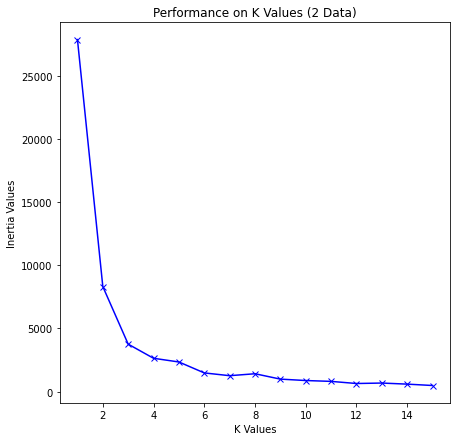

In [36]:
plt.figure(figsize=(7,7))
plt.plot([i for i in data_run_history["k_runs"].keys()], [ data_run_history["k_runs"][i]["inertia"] for i in data_run_history["k_runs"].keys()], 'bx-')
plt.xlabel("K Values")
plt.ylabel("Inertia Values")
plt.title("Performance on K Values (2 Data)")

Best K = 3

In [6]:
df_processing = df_training.copy()
df_processing = df_processing.filter(items=["id", "Umur", "Kanal_Penjualan"])
df_processing["Cluster"] = data_run_history["k_runs"][3]["cluster"]
df_processing

,id,Umur,Kanal_Penjualan,Cluster
0,1,30.0,152.0,1.0
1,2,48.0,29.0,0.0
2,4,58.0,124.0,2.0
3,6,21.0,152.0,1.0
4,9,20.0,160.0,1.0
...,...,...,...,...
166391,285827,23.0,152.0,1.0
166392,285828,21.0,152.0,1.0
166393,285829,23.0,152.0,1.0
166394,285830,68.0,124.0,2.0


Silhoutte Score

In [7]:
X = df_processing.filter(items=["Umur", "Kanal_Penjualan"])
y = df_processing["Cluster"]
sil_sample = silhouette_samples(X, y)
sil_sample

array([0.76436912, 0.86902934, 0.62644537, ..., 0.83926655, 0.56977806,
       0.87456553])

rata-rata silhouette cluster 0 : 0.8257767814719873
rata-rata silhouette cluster 1 : 0.7202374958910577
rata-rata silhouette cluster 2 : 0.4340254817554069
rata-rata silhouette : 0.6600132530394839


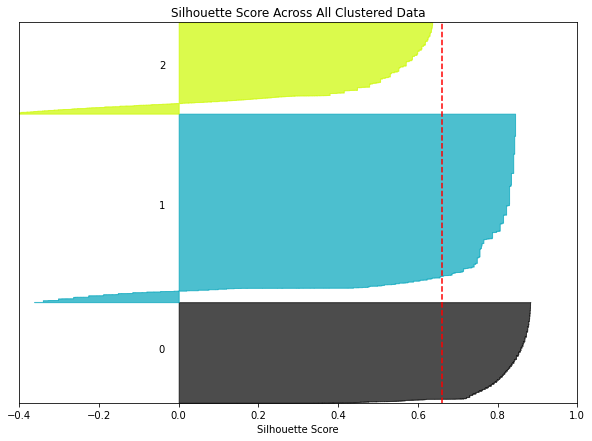

In [34]:
# ref : https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
import statistics
n_clusters = len(df_processing["Cluster"].unique())
fig = plt.figure()
ax = plt.axes()
ax.tick_params(left=False, labelleft=False)
fig.set_size_inches(10, 7)
ax.set_xlim([-0.4, 1])
ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
ax.set_title("Silhouette Score Across All Clustered Data")
ax.set_xlabel("Silhouette Score")
y_lower = 10
sil_total = 0
for i in range(n_clusters):
    ith_cluster_silhouette_values = \
            sil_sample[df_processing["Cluster"] == i]
    print("rata-rata silhouette cluster",i, ":" , statistics.mean(ith_cluster_silhouette_values))
    sil_total += statistics.mean(ith_cluster_silhouette_values)
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / n_clusters)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples
    
print("rata-rata silhouette :", (sil_total/n_clusters) )
ax.axvline(x=(sil_total/n_clusters), color="red", linestyle="--")

Text(0.5, 1.0, 'Scatter Plot Clustering')

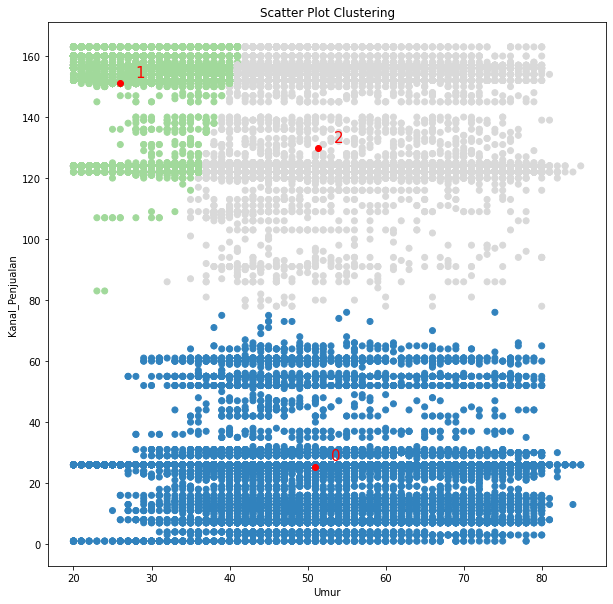

In [32]:
fig, ax = plt.subplots()
fig.set_size_inches((10,10))
ax.scatter(df_processing["Umur"], df_processing["Kanal_Penjualan"], c=df_processing["Cluster"], cmap="tab20c")
ax.scatter(data_run_history["k_runs"][3]["points"][:, 0], data_run_history["k_runs"][3]["points"][:, 1], color="red")
for i in range(len(data_run_history["k_runs"][3]["points"])):
    ax.text(data_run_history["k_runs"][3]["points"][i, 0]+2, data_run_history["k_runs"][3]["points"][i, 1]+2, str(i), color="red", fontsize = 15)
ax.set_xlabel("Umur")
ax.set_ylabel("Kanal_Penjualan")
ax.set_title("Scatter Plot Clustering")

# Eksperimen Lain

In [9]:
# df_training.to_csv("../data/processed/kendaraan_train_processed.csv")
df_training = pd.read_csv("https://raw.githubusercontent.com/kaenova/Malin_Tubes1/main/data/processed/kendaraan_train_processed.csv")
df_training

,id,Umur,Kode_Daerah,Premi,Kanal_Penjualan,Lama_Berlangganan
0,1,30.0,33.0,28029.0,152.0,97.0
1,2,48.0,39.0,25800.0,29.0,158.0
2,4,58.0,48.0,2630.0,124.0,63.0
3,6,21.0,35.0,22735.0,152.0,171.0
4,9,20.0,8.0,30786.0,160.0,31.0
...,...,...,...,...,...,...
166391,285827,23.0,4.0,25988.0,152.0,217.0
166392,285828,21.0,46.0,44686.0,152.0,50.0
166393,285829,23.0,50.0,49751.0,152.0,226.0
166394,285830,68.0,7.0,30503.0,124.0,270.0


## 2 Atribut (Lama_Berlangganan dan Umur)

In [7]:
# # No need to train again, i've already save the clusters
# # But if you want to try the training part, just uncomment this

# MAX_K = 15

# import pandas as pd

# data_run_history = {
#   "data" : "2 Data Lama Berlangganan dan Umur", 
#   "k_runs" : {}
# }

# for i in range(1, MAX_K+1):
#   print("==== K:", i, "====" )
#   run_data = {
#     "points" : None,
#     "cluster" : None,
#     "inertia" : None
#   }
  
#   model = KMeans(df_training.filter(items=["Umur","Lama_Berlangganan"]))
#   run_data["cluster"] = model.fit_predict(k_num=i, conv_threshold=1e-15)
#   run_data["inertia"] = model.inertia
#   run_data["points"] = model.point
#   data_run_history["k_runs"][i] = run_data

==== K: 1 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Umur Lama_Berlangganan ]
STEP: 1
It's convergence!
==== K: 2 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Umur Lama_Berlangganan ]
STEP: 1
STEP: 2
STEP: 3
STEP: 4
STEP: 5
STEP: 6
STEP: 7
STEP: 8
STEP: 9
It's convergence!
==== K: 3 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Umur Lama_Berlangganan ]
STEP: 1
STEP: 2
STEP: 3
STEP: 4
STEP: 5
STEP: 6
STEP: 7
STEP: 8
STEP: 9
STEP: 10
STEP: 11
STEP: 12
STEP: 13
STEP: 14
STEP: 15
STEP: 16
STEP: 17
STEP: 18
STEP: 19
STEP: 20
STEP: 21
STEP: 22
STEP: 23
STEP: 24
STEP: 25
STEP: 26
STEP: 27
STEP: 28
STEP: 29
STEP: 30
STEP: 31
STEP: 32
STEP: 33
It's convergence!
==== K: 4 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Umur Lama_Berlangganan ]
STEP: 1
STEP: 2
STEP: 3
STEP: 4
STEP: 5
STEP: 6
STEP: 7
STEP: 8
STEP: 9
STEP: 10
STEP: 11
STEP: 12
STEP: 13
It's convergence!
==== K: 5 ====
K-Means akan ditentukan oleh atribut-

In [8]:
# # Jika melakukan training, untuk save variable training, uncomment cell ini
# FILE_NAME = "2data_umur_berlangganan_15k.pckl"
# f = open('./saved_vars/'+FILE_NAME, 'wb')
# pickle.dump(data_run_history, f)
# f.close()

In [11]:
# Jika melakukan training, anda dapat comment cell ini, karena hanya akan me-load training history untuk laporan
data_run_history = pickle.load(urlopen("https://raw.githubusercontent.com/kaenova/Malin_Tubes1/main/notebooks/saved_vars/2data_umur_berlangganan_15k.pckl"))
data_run_history

{'data': '2 Data Lama Berlangganan dan Umur',
 'k_runs': {1: {'points': array([[ 38.66680689, 154.30959879]]),
   'cluster': array([0., 0., 0., ..., 0., 0., 0.]),
   'inertia': 23420.36168853923},
  2: {'points': array([[ 38.6688567 ,  81.86455736],
          [ 38.66474671, 227.1212826 ]]),
   'cluster': array([0., 1., 0., ..., 1., 1., 0.]),
   'inertia': 12911.469345241725},
  3: {'points': array([[ 59.82436709, 156.75917227],
          [ 32.11226192,  76.41980167],
          [ 31.62763946, 231.99966356]]),
   'cluster': array([1., 0., 0., ..., 2., 0., 1.]),
   'inertia': 8628.502703498556},
  4: {'points': array([[ 27.70841246,  82.10065053],
          [ 54.01300753, 227.06199035],
          [ 27.16455003, 227.2636423 ],
          [ 54.6979044 ,  81.66567577]]),
   'cluster': array([0., 1., 3., ..., 2., 1., 3.]),
   'inertia': 5975.9905442558875},
  5: {'points': array([[ 26.69372037,  77.94221223],
          [ 56.49461574, 243.3340564 ],
          [ 56.35542804,  64.46207597],
     

Text(0.5, 1.0, 'Performance on K Values (2 Data)')

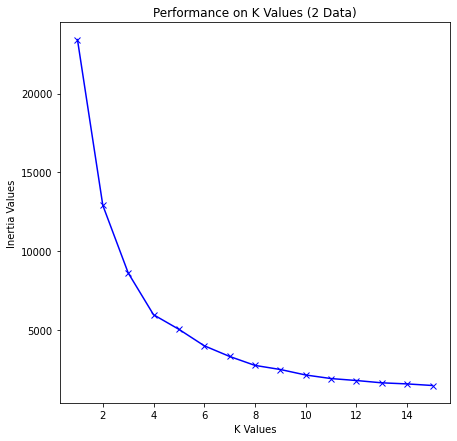

In [12]:
plt.figure(figsize=(7,7))
plt.plot([i for i in data_run_history["k_runs"].keys()], [ data_run_history["k_runs"][i]["inertia"] for i in data_run_history["k_runs"].keys()], 'bx-')
plt.xlabel("K Values")
plt.ylabel("Inertia Values")
plt.title("Performance on K Values (2 Data)")

Best K = 4

rata-rata silhouette cluster 0 : 0.15913907024846893
rata-rata silhouette cluster 1 : 0.12296653748657319
rata-rata silhouette cluster 2 : 0.16131818623457847
rata-rata silhouette cluster 3 : 0.12418999939000122
rata-rata silhouette : 0.14190344833990545


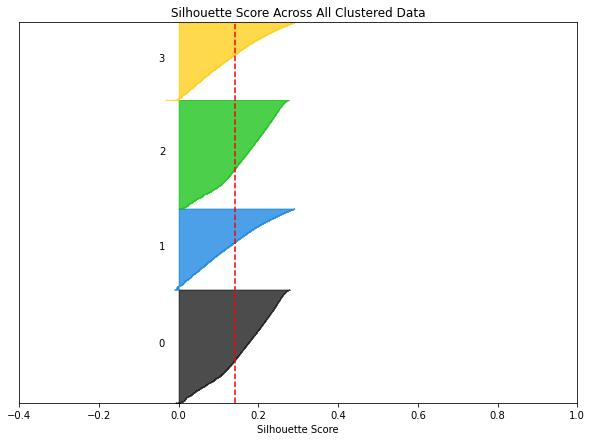

In [13]:
df_processing = df_training.copy()
df_processing = df_processing.filter(items=["id", "Umur", "Lama_Berlangganan"])
df_processing["Cluster"] = data_run_history["k_runs"][4]["cluster"]
X = df_processing.filter(items=["Umur", "Lama_Berlangganan"])
y = df_processing["Cluster"]
sil_sample = silhouette_samples(X, y)
# ref : https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
import statistics
n_clusters = len(df_processing["Cluster"].unique())
fig = plt.figure()
ax = plt.axes()
ax.tick_params(left=False, labelleft=False)
fig.set_size_inches(10, 7)
ax.set_xlim([-0.4, 1])
ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
ax.set_title("Silhouette Score Across All Clustered Data")
ax.set_xlabel("Silhouette Score")
y_lower = 10
sil_total = 0
for i in range(n_clusters):
    ith_cluster_silhouette_values = \
            sil_sample[df_processing["Cluster"] == i]
    print("rata-rata silhouette cluster",i, ":" , statistics.mean(ith_cluster_silhouette_values))
    sil_total += statistics.mean(ith_cluster_silhouette_values)
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / n_clusters)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples
    
print("rata-rata silhouette :", (sil_total/n_clusters) )
ax.axvline(x=(sil_total/n_clusters), color="red", linestyle="--")

## 2 Atribut (Umur dan Premi)

In [9]:
# # No need to train again, i've already save the clusters
# # But if you want to try the training part, just uncomment this

# MAX_K = 15

# import pandas as pd

# data_run_history = {
#   "data" : "2 Data Premi dan Umur", 
#   "k_runs" : {}
# }

# for i in range(1, MAX_K+1):
#   print("==== K:", i, "====" )
#   run_data = {
#     "points" : None,
#     "cluster" : None,
#     "inertia" : None
#   }
  
#   model = KMeans(df_training.filter(items=["Umur","Premi"]))
#   run_data["cluster"] = model.fit_predict(k_num=i, conv_threshold=1e-15)
#   run_data["inertia"] = model.inertia
#   run_data["points"] = model.point
#   data_run_history["k_runs"][i] = run_data

==== K: 1 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Umur Premi ]
STEP: 1
It's convergence!
==== K: 2 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Umur Premi ]
STEP: 1
STEP: 2
STEP: 3
STEP: 4
STEP: 5
STEP: 6
STEP: 7
STEP: 8
STEP: 9
STEP: 10
STEP: 11
STEP: 12
STEP: 13
STEP: 14
STEP: 15
STEP: 16
STEP: 17
STEP: 18
STEP: 19
STEP: 20
STEP: 21
STEP: 22
STEP: 23
STEP: 24
STEP: 25
STEP: 26
STEP: 27
STEP: 28
It's convergence!
==== K: 3 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Umur Premi ]
STEP: 1
STEP: 2
STEP: 3
STEP: 4
STEP: 5
STEP: 6
STEP: 7
STEP: 8
STEP: 9
STEP: 10
STEP: 11
STEP: 12
STEP: 13
STEP: 14
STEP: 15
STEP: 16
STEP: 17
STEP: 18
STEP: 19
It's convergence!
==== K: 4 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Umur Premi ]
STEP: 1
STEP: 2
STEP: 3
STEP: 4
STEP: 5
STEP: 6
STEP: 7
STEP: 8
STEP: 9
STEP: 10
STEP: 11
STEP: 12
STEP: 13
STEP: 14
STEP: 15
STEP: 16
STEP: 17
STEP: 18
STEP: 19
STEP: 20
It's conve

STEP: 9
STEP: 10
STEP: 11
STEP: 12
STEP: 13
STEP: 14
STEP: 15
STEP: 16
STEP: 17
STEP: 18
STEP: 19
STEP: 20
STEP: 21
STEP: 22
STEP: 23
STEP: 24
STEP: 25
STEP: 26
STEP: 27
STEP: 28
STEP: 29
STEP: 30
STEP: 31
STEP: 32
STEP: 33
STEP: 34
STEP: 35
STEP: 36
STEP: 37
STEP: 38
STEP: 39
STEP: 40
STEP: 41
STEP: 42
STEP: 43
STEP: 44
STEP: 45
STEP: 46
STEP: 47
STEP: 48
STEP: 49
STEP: 50
STEP: 51
STEP: 52
STEP: 53
STEP: 54
STEP: 55
STEP: 56
STEP: 57
STEP: 58
STEP: 59
STEP: 60
STEP: 61
STEP: 62
STEP: 63
STEP: 64
STEP: 65
STEP: 66
STEP: 67
STEP: 68
STEP: 69
STEP: 70
STEP: 71
STEP: 72
STEP: 73
STEP: 74
STEP: 75
STEP: 76
STEP: 77
STEP: 78
STEP: 79
STEP: 80
STEP: 81
STEP: 82
STEP: 83
STEP: 84
STEP: 85
STEP: 86
STEP: 87
STEP: 88
STEP: 89
STEP: 90
STEP: 91
STEP: 92
STEP: 93
STEP: 94
It's convergence!
==== K: 15 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Umur Premi ]
STEP: 1
STEP: 2
STEP: 3
STEP: 4
STEP: 5
STEP: 6
STEP: 7
STEP: 8
STEP: 9
STEP: 10
STEP: 11
STEP: 12
STEP: 13
STEP: 14
STE

In [10]:
# # Jika melakukan training, untuk save variable training, uncomment cell ini
# FILE_NAME = "2data_umur_premi_15k.pckl"
# f = open('./saved_vars/'+FILE_NAME, 'wb')
# pickle.dump(data_run_history, f)
# f.close()

In [14]:
# Jika melakukan training, anda dapat comment cell ini, karena hanya akan me-load training history untuk laporan
data_run_history = pickle.load(urlopen("https://raw.githubusercontent.com/kaenova/Malin_Tubes1/main/notebooks/saved_vars/2data_umur_premi_15k.pckl"))
data_run_history

{'data': '2 Data Premi dan Umur',
 'k_runs': {1: {'points': array([[   38.66680689, 29214.08429289]]),
   'cluster': array([0., 0., 0., ..., 0., 0., 0.]),
   'inertia': 19742.148334027388},
  2: {'points': array([[5.45190068e+01, 3.46579437e+04],
          [2.86982752e+01, 2.57907560e+04]]),
   'cluster': array([1., 0., 0., ..., 1., 0., 0.]),
   'inertia': 12631.340366548542},
  3: {'points': array([[5.41441485e+01, 3.78045490e+04],
          [4.10991564e+01, 2.96973072e+03],
          [2.69711448e+01, 3.29704788e+04]]),
   'cluster': array([2., 0., 1., ..., 2., 0., 0.]),
   'inertia': 6519.965552075672},
  4: {'points': array([[5.40947412e+01, 3.79002864e+04],
          [2.92941283e+01, 3.37313620e+03],
          [5.45914699e+01, 3.33220783e+03],
          [2.70108987e+01, 3.30876964e+04]]),
   'cluster': array([3., 0., 2., ..., 3., 0., 0.]),
   'inertia': 5412.974664812321},
  5: {'points': array([[2.52073434e+01, 3.29698032e+04],
          [5.59810688e+01, 3.10205592e+03],
         

Text(0.5, 1.0, 'Performance on K Values (2 Data)')

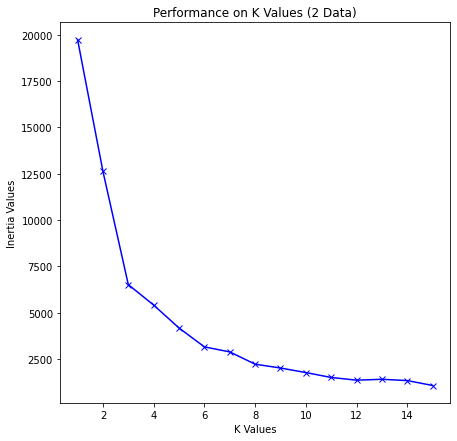

In [15]:
plt.figure(figsize=(7,7))
plt.plot([i for i in data_run_history["k_runs"].keys()], [ data_run_history["k_runs"][i]["inertia"] for i in data_run_history["k_runs"].keys()], 'bx-')
plt.xlabel("K Values")
plt.ylabel("Inertia Values")
plt.title("Performance on K Values (2 Data)")

best K = 3

rata-rata silhouette cluster 0 : 0.02219018947199481
rata-rata silhouette cluster 1 : -0.024697398967685125
rata-rata silhouette cluster 2 : 0.0321666077955415
rata-rata silhouette : 0.009886466099950395


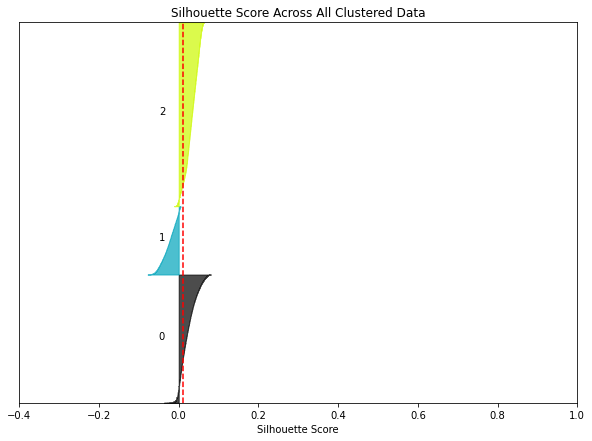

In [16]:
df_processing = df_training.copy()
df_processing = df_processing.filter(items=["id", "Umur", "Lama_Berlangganan"])
df_processing["Cluster"] = data_run_history["k_runs"][3]["cluster"]
X = df_processing.filter(items=["Umur", "Lama_Berlangganan"])
y = df_processing["Cluster"]
sil_sample = silhouette_samples(X, y)
# ref : https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
import statistics
n_clusters = len(df_processing["Cluster"].unique())
fig = plt.figure()
ax = plt.axes()
ax.tick_params(left=False, labelleft=False)
fig.set_size_inches(10, 7)
ax.set_xlim([-0.4, 1])
ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
ax.set_title("Silhouette Score Across All Clustered Data")
ax.set_xlabel("Silhouette Score")
y_lower = 10
sil_total = 0
for i in range(n_clusters):
    ith_cluster_silhouette_values = \
            sil_sample[df_processing["Cluster"] == i]
    print("rata-rata silhouette cluster",i, ":" , statistics.mean(ith_cluster_silhouette_values))
    sil_total += statistics.mean(ith_cluster_silhouette_values)
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / n_clusters)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples
    
print("rata-rata silhouette :", (sil_total/n_clusters) )
ax.axvline(x=(sil_total/n_clusters), color="red", linestyle="--")

## 2 Atribut (Lama_Berlangganan dan Premi)

In [11]:
# # No need to train again, i've already save the clusters
# # But if you want to try the training part, just uncomment this

# MAX_K = 15

# import pandas as pd

# data_run_history = {
#   "data" : "2 Data Lama_Berlangganan dan Premi", 
#   "k_runs" : {}
# }

# for i in range(1, MAX_K+1):
#   print("==== K:", i, "====" )
#   run_data = {
#     "points" : None,
#     "cluster" : None,
#     "inertia" : None
#   }
  
#   model = KMeans(df_training.filter(items=["Lama_Berlangganan","Premi"]))
#   run_data["cluster"] = model.fit_predict(k_num=i, conv_threshold=1e-15)
#   run_data["inertia"] = model.inertia
#   run_data["points"] = model.point
#   data_run_history["k_runs"][i] = run_data

==== K: 1 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Lama_Berlangganan Premi ]
STEP: 1
It's convergence!
==== K: 2 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Lama_Berlangganan Premi ]
STEP: 1
STEP: 2
STEP: 3
STEP: 4
STEP: 5
STEP: 6
STEP: 7
STEP: 8
STEP: 9
STEP: 10
STEP: 11
STEP: 12
STEP: 13
STEP: 14
STEP: 15
STEP: 16
It's convergence!
==== K: 3 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Lama_Berlangganan Premi ]
STEP: 1
STEP: 2
STEP: 3
STEP: 4
STEP: 5
STEP: 6
STEP: 7
STEP: 8
STEP: 9
STEP: 10
STEP: 11
It's convergence!
==== K: 4 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Lama_Berlangganan Premi ]
STEP: 1
STEP: 2
STEP: 3
STEP: 4
STEP: 5
STEP: 6
STEP: 7
STEP: 8
STEP: 9
STEP: 10
STEP: 11
STEP: 12
STEP: 13
STEP: 14
STEP: 15
STEP: 16
STEP: 17
STEP: 18
STEP: 19
STEP: 20
STEP: 21
STEP: 22
STEP: 23
STEP: 24
STEP: 25
It's convergence!
==== K: 5 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[

STEP: 9
STEP: 10
STEP: 11
STEP: 12
STEP: 13
STEP: 14
STEP: 15
STEP: 16
STEP: 17
STEP: 18
STEP: 19
STEP: 20
STEP: 21
STEP: 22
STEP: 23
STEP: 24
STEP: 25
STEP: 26
STEP: 27
STEP: 28
STEP: 29
STEP: 30
STEP: 31
STEP: 32
STEP: 33
STEP: 34
STEP: 35
STEP: 36
STEP: 37
STEP: 38
STEP: 39
STEP: 40
STEP: 41
STEP: 42
STEP: 43
STEP: 44
STEP: 45
STEP: 46
STEP: 47
STEP: 48
STEP: 49
STEP: 50
STEP: 51
STEP: 52
STEP: 53
STEP: 54
STEP: 55
STEP: 56
STEP: 57
STEP: 58
STEP: 59
STEP: 60
STEP: 61
STEP: 62
STEP: 63
STEP: 64
STEP: 65
STEP: 66
STEP: 67
STEP: 68
STEP: 69
STEP: 70
STEP: 71
STEP: 72
STEP: 73
STEP: 74
STEP: 75
STEP: 76
STEP: 77
STEP: 78
STEP: 79
STEP: 80
STEP: 81
STEP: 82
STEP: 83
STEP: 84
STEP: 85
STEP: 86
STEP: 87
STEP: 88
STEP: 89
STEP: 90
STEP: 91
STEP: 92
STEP: 93
It's convergence!


In [12]:
# # Jika melakukan training, untuk save variable training, uncomment cell ini
# FILE_NAME = "2data_berlangganan_premi_15k.pckl"
# f = open('./saved_vars/'+FILE_NAME, 'wb')
# pickle.dump(data_run_history, f)
# f.close()

In [17]:
# Jika melakukan training, anda dapat comment cell ini, karena hanya akan me-load training history untuk laporan
data_run_history = pickle.load(urlopen("https://raw.githubusercontent.com/kaenova/Malin_Tubes1/main/notebooks/saved_vars/2data_berlangganan_premi_15k.pckl"))
data_run_history

{'data': '2 Data Lama_Berlangganan dan Premi',
 'k_runs': {1: {'points': array([[  154.30959879, 29214.08429289]]),
   'cluster': array([0., 0., 0., ..., 0., 0., 0.]),
   'inertia': 24334.730089861838},
  2: {'points': array([[  227.18390902, 29267.16267065],
          [   81.92763536, 29161.36451845]]),
   'cluster': array([1., 0., 1., ..., 0., 0., 1.]),
   'inertia': 13825.823807553425},
  3: {'points': array([[  154.27769576,  3302.66535446],
          [   81.39195973, 34993.97767569],
          [  227.61918532, 35057.34549505]]),
   'cluster': array([1., 2., 0., ..., 2., 2., 1.]),
   'inertia': 8466.504305420827},
  4: {'points': array([[  227.01551089,  3525.23356815],
          [   81.86223586, 35097.77363948],
          [   81.87461637,  3561.08861893],
          [  227.14552322, 35138.25788343]]),
   'cluster': array([1., 3., 2., ..., 3., 3., 1.]),
   'inertia': 6610.061301900753},
  5: {'points': array([[  251.61378283, 35118.54655762],
          [   81.84858126,  3331.7521589

Text(0.5, 1.0, 'Performance on K Values (2 Data)')

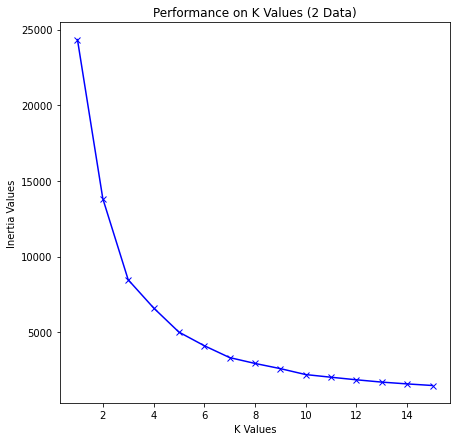

In [18]:
plt.figure(figsize=(7,7))
plt.plot([i for i in data_run_history["k_runs"].keys()], [ data_run_history["k_runs"][i]["inertia"] for i in data_run_history["k_runs"].keys()], 'bx-')
plt.xlabel("K Values")
plt.ylabel("Inertia Values")
plt.title("Performance on K Values (2 Data)")

best k = 3

rata-rata silhouette cluster 0 : -0.42130054784649185
rata-rata silhouette cluster 1 : 0.4323379410986337
rata-rata silhouette cluster 2 : 0.4341023880949228
rata-rata silhouette : 0.14837992711568823


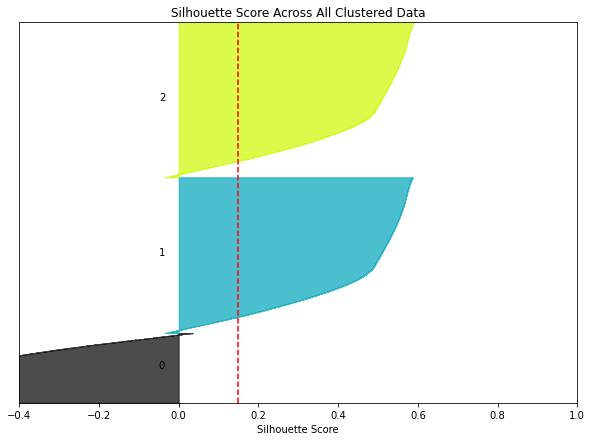

In [19]:
df_processing = df_training.copy()
df_processing = df_processing.filter(items=["id", "Umur", "Lama_Berlangganan"])
df_processing["Cluster"] = data_run_history["k_runs"][3]["cluster"]
X = df_processing.filter(items=["Umur", "Lama_Berlangganan"])
y = df_processing["Cluster"]
sil_sample = silhouette_samples(X, y)
# ref : https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
import statistics
n_clusters = len(df_processing["Cluster"].unique())
fig = plt.figure()
ax = plt.axes()
ax.tick_params(left=False, labelleft=False)
fig.set_size_inches(10, 7)
ax.set_xlim([-0.4, 1])
ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
ax.set_title("Silhouette Score Across All Clustered Data")
ax.set_xlabel("Silhouette Score")
y_lower = 10
sil_total = 0
for i in range(n_clusters):
    ith_cluster_silhouette_values = \
            sil_sample[df_processing["Cluster"] == i]
    print("rata-rata silhouette cluster",i, ":" , statistics.mean(ith_cluster_silhouette_values))
    sil_total += statistics.mean(ith_cluster_silhouette_values)
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / n_clusters)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples
    
print("rata-rata silhouette :", (sil_total/n_clusters) )
ax.axvline(x=(sil_total/n_clusters), color="red", linestyle="--")